# ND2 extractor
* An nd2 extractor using the package `nd2` from `https://pypi.org/project/nd2/`.
* Supports different dimensions of nd2 files (works fine if there is only one time point or one field of view).
* Adjustable threshold for parallelisation to avoid unnecessary `joblib` overheads.
* Automatic colour channel identification from metadata.
* Human-readable metadata extraction to `.txt` files.
* Metadata output in a `.json` format for loading back into your pipeline later as a dictionary.

In [3]:
import numpy as np
import nd2
import os
from PIL import Image
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json

## 1. Get metadata
* `generate_metadata_txt` outputs a text file with human readable metadata about the experiment.
* `generate_metadata_json` outputs a json file with various metadata from your experiment which can be loaded back in as a dictionary at various point of your pipeline.

In [4]:
def generate_metadata_txt(nd2_file, outfile):
    """
    Outputs a plain text file summarising the metadata in a human readable format.
    """
    with nd2.ND2File(nd2_file) as ndfile:
        with open(outfile, "w") as f:
            f.write("nd2 file is {} \n\n".format(nd2_file))
            for key, value in ndfile.text_info.items():
                f.write(key)
                f.write(": \n\n")
                f.write(value)
                f.write("\n\n")
            f.write("Pixel to micron conversion: \n")
            f.write("x voxel size is {} microns/pixel \n".format(str(ndfile.voxel_size().x)))
            f.write("y voxel size is {} microns/pixel \n".format(str(ndfile.voxel_size().y)))

In [5]:
import os
# nd2_file = "20241023_SB8_FDAA.nd2"
# nd2_file = "HADA_W1_7_T_singledye.nd2"
# nd2_file = "Barcoding_HADA_40x_T1.nd2"
# nd2_file = "Barcoding_DAPI_40x_T1.nd2"
# nd2_file = "Barcoding_HADA_DAPI_40x_T1_1.nd2"
# nd2_file ="20241108_RADA.nd2"
# nd2_file = "20241114_Leakage.nd2"
# nd2_file = "20241205_nucleoid2.nd2"
# nd2_file = "20241207_membrane.nd2"
# nd2_file = "20241208_membrane_nucleoid.nd2"
# nd2_file = "20250205_memexpo.nd2"
# nd2_file = "20250212_both001.nd2"
nd2_file = "20241114_Leakage.nd2"
# barcode20250219_1000.nd2
# barcode20250307_0010.nd2
# barcode20250310_1100.nd2
# barcode20250324_0110.nd2
# barcode20250324_0111.nd2
# barcode20250324_1001.nd2
# barcode20250319_0011.nd2


In [6]:
outfile = "metadata_nd2_" + nd2_file.split(".")[0] + ".txt"
generate_metadata_txt(nd2_file, outfile)

In [7]:
import json
import nd2

def generate_metadata_json(nd2_file, json_outfile, save_file=True): 
    """
    Outputs nd2 metadata in a JSON file that can be loaded back as a dictionary.
    This function is designed to handle .nd2 files of varying lengths and structures.
    """
    nd2_metadata = dict()
    with nd2.ND2File(nd2_file) as ndfile:
        # Basic file and dimensional info
        nd2_metadata["file_path"] = ndfile.path
        nd2_metadata["shape"] = ndfile.shape
        nd2_metadata["ndim"] = ndfile.ndim
        nd2_metadata["dtype"] = str(ndfile.dtype)
        nd2_metadata["sizes"] = ndfile.sizes
        nd2_metadata["is_rgb"] = ndfile.is_rgb
        
        # Handling Field of View (FOV) information if available
        FOV_xyz_PFS = dict()
        if hasattr(ndfile.experiment[0].parameters, 'points'):
            for count, position in enumerate(ndfile.experiment[0].parameters.points):
                FOV_xyz_PFS[f"xy{str(count).zfill(3)}"] = (position.stagePositionUm, position.pfsOffset)
        nd2_metadata["FOV_xyz_PFS_key"] = {"FOV_key": "([x, y, z], PFS_offset)"}
        nd2_metadata["FOV_xyz_PFS"] = FOV_xyz_PFS if FOV_xyz_PFS else None

        # General info about axes
        nd2_metadata["axes_order"] = ["x", "y", "z"]

        # Axis calibration information
        axes_calibrated = getattr(ndfile.metadata.channels[0].volume, 'axesCalibrated', None)
        if isinstance(axes_calibrated, dict):
            nd2_metadata["axes_calibrated"] = axes_calibrated
        else:
            nd2_metadata["axes_calibrated"] = str(axes_calibrated) if axes_calibrated else None

        # Convert axesCalibration to a JSON-compatible format
        nd2_metadata["axes_calibration"] = list(getattr(ndfile.metadata.channels[0].volume, 'axesCalibration', []))
        nd2_metadata["FOV_size_in_pixels"] = getattr(ndfile.metadata.channels[0].volume, 'voxelCount', None)
        nd2_metadata["microns_per_pixel"] = float(ndfile.metadata.channels[0].volume.axesCalibration[0]) if ndfile.metadata.channels[0].volume.axesCalibration else None

        # Timepoint information
        nd2_metadata["num_timepoints"] = ndfile.sizes.get('T', 1)
        if hasattr(ndfile.experiment[0].parameters, 'periodMs'):
            nd2_metadata["imaging_interval_ms"] = ndfile.experiment[0].parameters.periodMs
            nd2_metadata["imaging_interval_ms_mean"] = ndfile.experiment[0].parameters.periodDiff.avg if hasattr(ndfile.experiment[0].parameters.periodDiff, 'avg') else None
            nd2_metadata["imaging_interval_ms_max"] = ndfile.experiment[0].parameters.periodDiff.max if hasattr(ndfile.experiment[0].parameters.periodDiff, 'max') else None
            nd2_metadata["imaging_interval_ms_min"] = ndfile.experiment[0].parameters.periodDiff.min if hasattr(ndfile.experiment[0].parameters.periodDiff, 'min') else None
        else:
            nd2_metadata["imaging_interval_ms"] = None
            nd2_metadata["imaging_interval_ms_mean"] = None
            nd2_metadata["imaging_interval_ms_max"] = None
            nd2_metadata["imaging_interval_ms_min"] = None
        
        # Channel information
        channel_list = []
        channel_dict_key = dict()
        channel_dict_key["channel_name"] = ("excitation_wavelength", "emission_wavelength")
        channel_lambdas = dict()
        for i, channel in enumerate(ndfile.metadata.channels):
            channel_name = channel.channel.name
            channel_list.append(channel_name)
            channel_lambdas[channel_name] = (channel.channel.excitationLambdaNm, channel.channel.emissionLambdaNm)
        nd2_metadata["channels"] = channel_list
        nd2_metadata["channel_wavelengths_key"] = channel_dict_key
        nd2_metadata["channel_wavelengths"] = channel_lambdas

        # Microscope and objective info
        microscope_data = ndfile.metadata.channels[0].microscope
        nd2_metadata["objective"] = microscope_data.objectiveName
        nd2_metadata["numerical_aperture"] = microscope_data.objectiveNumericalAperture
        nd2_metadata["objective_magnification"] = microscope_data.objectiveMagnification
        nd2_metadata["post_objective_magnification"] = microscope_data.zoomMagnification
        nd2_metadata["immersion_refractive_index"] = microscope_data.immersionRefractiveIndex
        nd2_metadata["camera_name"] = "Hamamatsu C14440-20UP SN:000470"  # Replace if dynamic info available

        # Save metadata as JSON if requested
        if save_file:
            with open(json_outfile, 'w') as f: 
                json.dump(nd2_metadata, f, default=str)  # Use default=str to handle any non-serializable types

    return nd2_metadata





In [8]:
# Generate JSON file with updated path handling
json_outfile = os.path.join(os.getcwd(), "metadata_nd2_" + os.path.basename(nd2_file).split(".")[0] + ".json")
nd2_metadata = generate_metadata_json(nd2_file, json_outfile, save_file=True)

print(f"Metadata file saved at: {json_outfile}")

Metadata file saved at: d:\PRISM\metadata_nd2_20241114_Leakage.json


## 2. Function definitions for nd2 extraction

In [9]:
# def get_nd2_dimensions(nd2_file):
#     """
#     Return a dict of the nd2 dimensions. Modifies the .sizes method to give a standardised output.
#     """
#     with nd2.ND2File(nd2_file) as ndfile:
#         dimensions = ndfile.sizes
#         if "T" not in dimensions.keys():
#             dimensions["T"] = 1
#         if "P" not in dimensions.keys():
#             dimensions["P"] = 1
#         if "C" not in dimensions.keys():
#             dimensions["C"] = 1
        
#         return dict(sorted(dimensions.items()))

def get_nd2_dimensions(nd2_file):
    """
    Return a dict of the nd2 dimensions. Modifies the .sizes method to give a standardized output.
    """
    with nd2.ND2File(nd2_file) as ndfile:
        # Make a copy of ndfile.sizes to allow modifications
        dimensions = dict(ndfile.sizes)
        
        # Add default values if certain dimensions are missing
        if "T" not in dimensions:
            dimensions["T"] = 1
        if "P" not in dimensions:
            dimensions["P"] = 1
        if "C" not in dimensions:
            dimensions["C"] = 1
        
        # Sort and return the modified dimensions dictionary
        return dict(sorted(dimensions.items()))

In [10]:
def get_channel_dict(nd2_file):
    """
    Returns a dictionary mapping the channel index to the channel name (colour)
    """
    channels = {}
    with nd2.ND2File(nd2_file) as ndfile:
        for i in range(len(ndfile.metadata.channels)): 
            channels[str(i)] = ndfile.metadata.channels[i].channel.name
    
    return channels

In [11]:
def create_joblib_packages(dimensions, parallelisation_min = 50, njobs_max = 16):
    """
    Split the largest dimension into packages to be parallelised along.
    Packages will be supplied as a nested list, with len(packages) = njobs
    """
    
    all_frames = []
    for p in range(dimensions["P"]):
        for c in range(dimensions["C"]):
            for t in range(dimensions["T"]):
                all_frames.append((p,c,t))
    
    ## if nd2 is small, it is better to avoid joblib overhead ##
    if dimensions["T"] * dimensions["P"] * dimensions["C"] < parallelisation_min:
        njobs = 1
    else:
        njobs = njobs_max
        
    #####     
    
    num_imgs = dimensions["P"] * dimensions["T"] * dimensions["C"]
    package_length = int(num_imgs/njobs)
    
    nd2_indices_dict = dict()
    FOV_counter = 0
    t_counter = 0
    ch_counter = 0
    for x in range(num_imgs):
        nd2_indices_dict[x] = [FOV_counter, t_counter, ch_counter]
        ch_counter = ch_counter + 1
        if ch_counter >= dimensions["C"]:
            ch_counter = 0
            t_counter = t_counter + 1
            if t_counter >= dimensions["T"]:
                t_counter = 0
                FOV_counter = FOV_counter + 1
                    
    packages = np.linspace(0, num_imgs, njobs, endpoint=False)
    indices = [int(x) for x in packages]
    indices[0] = 0
    
    # seems to fix it for njobs=1
    if njobs > 1:
        indices[-1] = len(nd2_indices_dict) - (package_length + 1)
    else:
        indices[-1] = len(nd2_indices_dict) - (package_length)
        
    joblib_packages = []
    for count, idx in enumerate(indices):
        if count <= len(indices)-2:
            # package = list(range(idx,indices[count+1]))
            package = all_frames[idx:indices[count+1]]
        else:
            # package = list(range(idx,idx+package_length+1))
            package = all_frames[idx:idx+package_length+1]
        joblib_packages.append(package)
    
    return njobs, joblib_packages, all_frames

In [12]:
def save_png(numpy_array, channels, p, c, t, save_dir):
    im = Image.fromarray(numpy_array)
    im.save("{}/xy{}_{}_T{}.png".format(save_dir, str(p).zfill(3), channels[str(c)], str(t).zfill(4)))

In [13]:
def extract_pngs(dask_array, save_dir, dimensions, channels, package):
    """
    Extract all png files from a package.
    """
    
    for tup in tqdm(package):
        p,c,t = tup
        
        ## based on nd2 dimensions, index dask array appropriately ##
        if dimensions["T"] != 1 and dimensions["P"] != 1 and dimensions["C"] != 1:
            arr = np.array(dask_array[t,p,c,:,:])
            save_png(arr, channels, p, c, t, save_dir)
        elif dimensions["T"] == 1 and dimensions["P"] == 1:
            arr = np.array(dask_array[c,:,:])
            save_png(arr, channels, p, c, t, save_dir)
        elif dimensions["T"] == 1 and dimensions["C"] == 1:
            arr = np.array(dask_array[p,:,:])
            save_png(arr, channels, p, c, t, save_dir)
        elif dimensions["P"] == 1 and dimensions["C"] == 1:
            arr = np.array(dask_array[t,:,:])
            save_png(arr, channels, p, c, t, save_dir)
        elif dimensions["T"] == 1:
            arr = np.array(dask_array[p,c,:,:])
            save_png(arr, channels, p, c, t, save_dir)
        elif dimensions["P"] == 1:
            arr = np.array(dask_array[t,c,:,:])
            save_png(arr, channels, p, c, t, save_dir)
        elif dimensions["C"] == 1:
            arr = np.array(dask_array[t,p,:,:])
            save_png(arr, channels, p, c, t, save_dir)
        
        else:
            arr = np.array(dask_array[:,:])
            save_png(arr, channels, p, c, t, save_dir)
        

In [14]:
def extract_all_pngs(nd2_file, save_dir, dimensions, channels, njobs, packages, backend="loky"):
    """
    Extract all png files from the nd2.
    """
    
    ## create a save folder ##
    try:
        os.mkdir(save_dir)
    except:
        print("Target save directory already exists!")
        pass
    
    ## generate dask array from nd2 file ##
    dask_array = nd2.imread(nd2_file, dask=True)
    
    ## extract pngs from nd2 file, avoiding joblib overhead for small jobs ##
    if njobs == 1:
        for package in packages:
            extract_pngs(dask_array, save_dir, dimensions, channels, package)
            
    ## parallelise for big jobs ##
    else:
        Parallel(n_jobs=njobs, backend=backend)(delayed(extract_pngs)(dask_array, save_dir, dimensions, channels, package) for package in tqdm(packages))

## 3. Extract all pngs

In [15]:
save_dir = "extracted"
dimensions = get_nd2_dimensions(nd2_file)
channels = get_channel_dict(nd2_file)
njobs, packages, all_frames = create_joblib_packages(dimensions)

In [ ]:
print(f"Extracting image with shape: {arr.shape}, dtype: {arr.dtype}")

In [ ]:
extract_all_pngs(nd2_file, save_dir, dimensions, channels, njobs, packages)

## 4. Additional metadata
* `temporal_frame_spacing` outputs a graph showing the consistency of the frame spacing in different channels
    * TODO: Plot all colour channels on same graph in `temporal_frame_spacing`

In [16]:
def temporal_frame_spacing(nd2_file, dimensions, channel=0, channels=None, outfile=None):
    """
    Plots the temporal frame spacing of a single colour channel.
    """
    frame_timings = []
    with nd2.ND2File(nd2_file) as f:
        for frame in range(channel,f.metadata.contents.frameCount,int(f.metadata.contents.frameCount/dimensions["T"])):
            frame_timings.append(f.frame_metadata(frame).channels[channel].time.relativeTimeMs/1000)
        
        single_channel_frame_list = list(range(channel,f.metadata.contents.frameCount,int(f.metadata.contents.frameCount/dimensions["T"]))) # if you want to plot frame number instead of time point
        frame_spacing = np.diff(frame_timings).tolist()
        time_points = list(range(len(frame_spacing)))
        
        if outfile:
            mean_frame_spacing = np.mean(frame_spacing)
            CV_frame_spacing = np.std(frame_spacing)/mean_frame_spacing
            with open(outfile, 'a') as f:
                f.write("\n")
                f.write("The mean temporal frame spacing in the {} channel is {}s and the coefficient of variation in the frame spacing is {}".format(channels[str(channel)], str(round(mean_frame_spacing, 4)), str(round(CV_frame_spacing, 5))))
        
        plt.plot(time_points, frame_spacing)
        plt.xlabel("Time point (-)")
        plt.ylabel("Frame spacing (s)")
        if channels:
            plt.title("Temporal frame spacing in {} channel".format(channels[str(channel)]))
        else:
            plt.title("Temporal frame spacing in channel {}".format(str(channel)))
        
        plt.savefig("{}_{}_channel_temporal_frame_spacing.png".format(nd2_file.split(".")[0], channels[str(channel)]), bbox_inches='tight', dpi=250)
        plt.show()

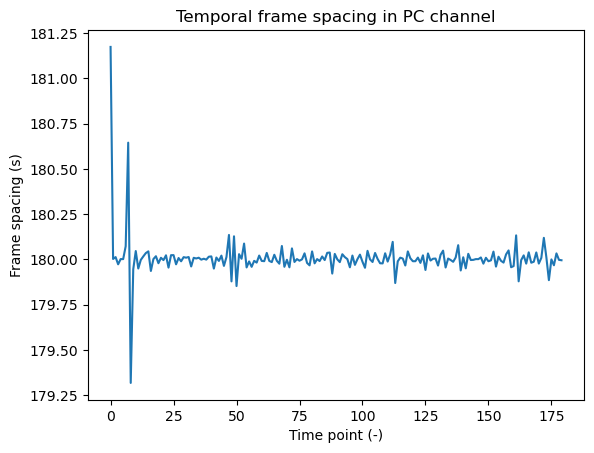

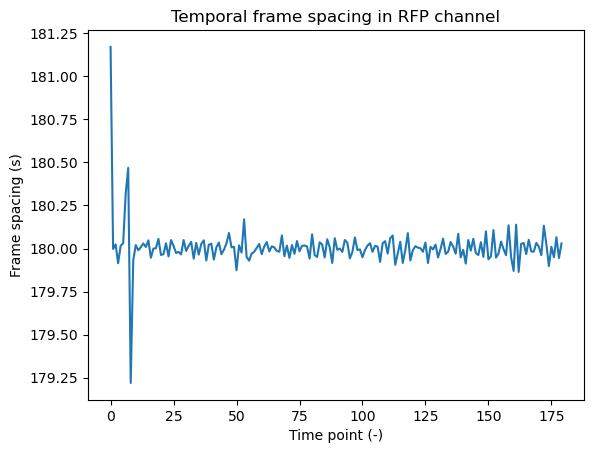

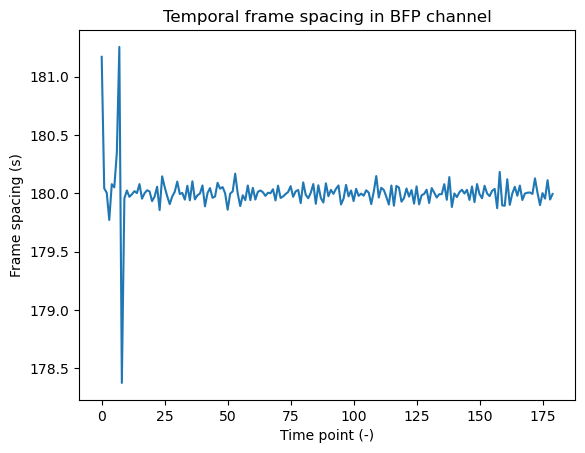

In [17]:
for i in range(len(channels)):
    temporal_frame_spacing(nd2_file, dimensions, channel=i, channels=channels, outfile=outfile)

# For multiple z location

In [1]:

import os
# os.environ["JOBLIB_TEMP_FOLDER"] = "C:/temp"
# os.makedirs("C:/temp", exist_ok=True)
os.makedirs("D:/temp", exist_ok=True)
os.environ["JOBLIB_TEMP_FOLDER"] = "D:/temp"


In [2]:
import numpy as np
import nd2
import os
from PIL import Image
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import json

###########################
# Metadata and Helper Functions
###########################

def generate_metadata_txt(nd2_file, outfile):
    """
    Outputs a plain text file summarizing the metadata in a human-readable format.
    """
    with nd2.ND2File(nd2_file) as ndfile:
        with open(outfile, "w") as f:
            f.write(f"nd2 file is {nd2_file} \n\n")
            for key, value in ndfile.text_info.items():
                f.write(f"{key}: \n\n{value}\n\n")
            f.write("Pixel to micron conversion: \n")
            f.write(f"x voxel size is {ndfile.voxel_size().x} microns/pixel \n")
            f.write(f"y voxel size is {ndfile.voxel_size().y} microns/pixel \n")

def generate_metadata_json(nd2_file, json_outfile, save_file=True): 
    """
    Outputs nd2 metadata in a JSON file that can be loaded back as a dictionary.
    """
    nd2_metadata = {}
    with nd2.ND2File(nd2_file) as ndfile:
        # Basic file and dimensional info
        nd2_metadata["file_path"] = ndfile.path
        nd2_metadata["shape"] = ndfile.shape
        nd2_metadata["ndim"] = ndfile.ndim
        nd2_metadata["dtype"] = str(ndfile.dtype)
        nd2_metadata["sizes"] = ndfile.sizes
        nd2_metadata["is_rgb"] = ndfile.is_rgb
        # (Other metadata processing omitted for brevity)
        if save_file:
            with open(json_outfile, 'w') as f: 
                json.dump(nd2_metadata, f, default=str)
    return nd2_metadata

def get_nd2_dimensions(nd2_file):
    """
    Return a dict of the nd2 dimensions.
    Adds default values if certain dimensions are missing.
    Ensures that the "Z" dimension is included.
    """
    with nd2.ND2File(nd2_file) as ndfile:
        dimensions = dict(ndfile.sizes)
        # Ensure defaults exist:
        dimensions.setdefault("T", 1)
        dimensions.setdefault("P", 1)
        dimensions.setdefault("C", 1)
        dimensions.setdefault("Z", 1)
        return dict(sorted(dimensions.items()))

def get_channel_dict(nd2_file):
    """
    Returns a dictionary mapping channel index to the channel name.
    """
    channels = {}
    with nd2.ND2File(nd2_file) as ndfile:
        for i, channel in enumerate(ndfile.metadata.channels): 
            channels[str(i)] = channel.channel.name
    return channels

###########################
# Directory Preparation
###########################

def pre_create_subfolders(base_save_dir, dimensions):
    """
    Pre-create subfolders for each z slice to prevent race conditions during parallel processing.
    """
    Z = dimensions.get("Z", 1)
    for z in range(Z):
        subfolder = os.path.join(base_save_dir, f"extracted_z{str(z).zfill(2)}")
        os.makedirs(subfolder, exist_ok=True)

###########################
# Packaging for Parallel Processing
###########################

def create_joblib_packages(dimensions, parallelisation_min=50, njobs_max=16):
    """
    Create a list of tuples representing indices for parallel processing.
    Includes the z dimension if greater than 1.
    """
    all_frames = []
    T = dimensions.get("T", 1)
    P = dimensions.get("P", 1)
    C = dimensions.get("C", 1)
    Z = dimensions.get("Z", 1)
    
    for p in range(P):
        for z in range(Z):
            for c in range(C):
                for t in range(T):
                    all_frames.append((p, z, c, t))
    
    num_imgs = len(all_frames)
    njobs = 1 if num_imgs < parallelisation_min else njobs_max
    package_length = int(num_imgs / njobs)
    packages = [all_frames[i:i + package_length] for i in range(0, num_imgs, package_length)]
    return njobs, packages, all_frames

###########################
# ND2-to-PNG Extraction Functions
###########################

def save_png(numpy_array, channels, p, c, t, z, base_save_dir):
    """
    Save the numpy array as a PNG file.
    The filename does not include the z index and is saved in a subfolder for that z.
    """
    subfolder = os.path.join(base_save_dir, f"extracted_z{str(z).zfill(2)}")
    im = Image.fromarray(numpy_array)
    filename = os.path.join(
        subfolder,
        f"xy{str(p).zfill(3)}_{channels[str(c)]}_T{str(t).zfill(4)}.png"
    )
    im.save(filename)

def extract_pngs(dask_array, base_save_dir, dimensions, channels, package):
    """
    Extract PNG files from a package.
    Uses indexing that includes the z dimension.
    """
    T = dimensions.get("T", 1)
    for p, z, c, t in tqdm(package):
        if T != 1:
            arr = np.array(dask_array[t, p, z, c, :, :])
        else:
            arr = np.array(dask_array[p, z, c, :, :])
        save_png(arr, channels, p, c, t, z, base_save_dir)

def extract_all_pngs(nd2_file, base_save_dir, dimensions, channels, njobs, packages, backend="loky"):
    """
    Extract all PNG files from the ND2 file using parallel processing.
    """
    os.makedirs(base_save_dir, exist_ok=True)
    pre_create_subfolders(base_save_dir, dimensions)
    
    dask_array = nd2.imread(nd2_file, dask=True)
    
    if njobs == 1:
        for package in packages:
            extract_pngs(dask_array, base_save_dir, dimensions, channels, package)
    else:
        Parallel(n_jobs=njobs, backend=backend)(
            delayed(extract_pngs)(dask_array, base_save_dir, dimensions, channels, package) 
            for package in tqdm(packages)
        )

###########################
# Run the Extraction Process
###########################

# nd2_file = "20250205_memexpo.nd2"
# nd2_file = "20250212_both001.nd2"
# nd2_file = "20250212_nuc.nd2"

# nd2_file = "20250219_bluebothexp.nd2"
# nd2_file = "20250219_bluememexp.nd2"
# nd2_file = "20250219_bluenucexp.nd2"
# nd2_file = "20250219_bluememexp101.nd2"
nd2_file = "20250328_nucleakage.nd2"
base_save_dir = "extracted"

dimensions = get_nd2_dimensions(nd2_file)
channels = get_channel_dict(nd2_file)
njobs, packages, all_frames = create_joblib_packages(dimensions)
extract_all_pngs(nd2_file, base_save_dir, dimensions, channels, njobs, packages)


c:\Users\kastu\miniconda3\envs\PRISM\lib\site-packages\dask\tokenize.py:242: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  mod.loads(out, buffers=buffers)


  0%|          | 0/17 [00:00<?, ?it/s]